### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import zipfile
import keras as ker
import json
import seaborn as sns
import glob
import shutil

from io import BytesIO
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
zipped_file = os.getenv("ziped_file")
sesnor_data = os.getenv("folder_name")
output_dir = os.getenv('sensor_heatmaps')
video_output = os.getenv('temperature_output')

In [3]:
def extract_zip(file_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    print(f'Files extracted to {extract_to}')

In [4]:
extract_zip(zipped_file, sesnor_data)

Files extracted to Sensor_data


In [5]:
def extract_data_from_sheet(df):
    sensor_name = df.iloc[0, 1]

    extracted_df = df.iloc[3:].reset_index(drop=True)

    extracted_df.columns = ['Time', 'Temperature', 'Humidity']
    extracted_df['Time'] = pd.to_datetime(extracted_df['Time'], format='%d-%m-%Y %H:%M')
    
    extracted_df['Sensor Info'] = sensor_name

    return extracted_df

In [6]:
def split_sensor_info(sensor_info):
    parts = sensor_info.split(' ')
    return pd.Series([parts[0], sensor_info])

In [7]:
def read_all_excel_files(directory):
    excel_files = glob.glob(os.path.join(directory, '**', '*.xlsx*'), recursive=True)
    data_frames = []

    for file in excel_files:
        print(f'Reading file: {file}')
        # Read each sheet in the Excel file
        xls = pd.ExcelFile(file)
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(file, sheet_name=sheet_name)
            extracted_df = extract_data_from_sheet(df)
            data_frames.append(extracted_df)

    # Combine all DataFrames
    combined_data = pd.concat(data_frames, ignore_index=True)

    # Apply the split_sensor_info function
    combined_data[['Sensor ID', 'Sensor Name']] = combined_data['Sensor Info'].apply(split_sensor_info)

    return combined_data

In [8]:
initial_data = read_all_excel_files(sesnor_data)

Reading file: Sensor_data\Data17052024-210552024\Sensor data[0474D,04750,04754,04756,04757,0475A,0475C,0475D,04762,04763,04765,04768,0476E,04771,04773,0477F,04787,04789,0478A,0478C](01_01_2024-20_05_2024) (1).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[0478E,04791,04792,04796,0479B,0479D,0479E,047A8,047AA,047AD,047B2,047B6,047B7,047B8,047BA,047BB,047BC,047C1](01_01_2024-20_05_2024).xlsx
Reading file: Sensor_data\Data17052024-210552024\Sensor data[047C2,047C4,047C5,047C7,047C8,047C9,047CA,047CB,047CD,047CE,047D2,047D3,047D4,047D6,047D7,047DD,047F7,04802,04804,0480E](01_01_2024-20_05_2024).xlsx


In [9]:
initial_data.head()

,Time,Temperature,Humidity,Sensor Info,Sensor ID,Sensor Name
0,2024-04-16 13:09:53,21.95,50.3,0474D T/RH IP67,0474D,0474D T/RH IP67
1,2024-04-16 13:14:52,22.5,34.7,0474D T/RH IP67,0474D,0474D T/RH IP67
2,2024-04-16 13:19:54,24.05,34.7,0474D T/RH IP67,0474D,0474D T/RH IP67
3,2024-04-16 13:24:53,24.25,34.7,0474D T/RH IP67,0474D,0474D T/RH IP67
4,2024-04-16 13:29:52,24.15,35.2,0474D T/RH IP67,0474D,0474D T/RH IP67


In [10]:
with open('sensor_placement.json', 'r') as file:
    data = json.load(file)

keys_list = list(data.keys())

In [11]:
initial_data['Sensor ID'] = pd.Categorical(initial_data['Sensor ID'], categories=keys_list, ordered=True)

In [12]:
df_sorted = initial_data.sort_values(by='Sensor ID')
df_sorted = df_sorted[~pd.isna(df_sorted['Sensor ID'])]
df_sorted['Sensor ID'] = df_sorted['Sensor ID'].astype(str)
df_sorted.reset_index(drop=True, inplace=True)

In [13]:
combined_data = df_sorted.copy()

In [14]:
combined_data = combined_data.drop_duplicates(subset=['Time', 'Sensor ID'])

In [15]:
combined_data = combined_data.drop('Sensor Info',axis=1)

In [16]:
combined_data.isnull().sum()

Time              0
Temperature    9351
Humidity       9351
Sensor ID         0
Sensor Name       0
dtype: int64

In [17]:
sample_dataset = combined_data.copy()

In [18]:
sample_dataset = sample_dataset[['Time','Temperature','Sensor ID']]

In [19]:
sample_dataset.head()

,Time,Temperature,Sensor ID
0,2024-05-14 02:18:22,15.25,047D6
1,2024-05-04 21:21:36,13.95,047D6
2,2024-05-04 21:26:37,13.65,047D6
3,2024-05-04 21:31:35,13.4,047D6
4,2024-05-04 21:36:36,13.4,047D6


In [20]:
sample_dataset['Temperature'] = sample_dataset['Temperature'].astype('float')

In [21]:
sensor_ids = sample_dataset['Sensor ID'].unique()
size_x = 7
size_y = 8

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Create the directory
os.makedirs(output_dir)

frames = []
for sensor_id in sensor_ids:
    sensor_data = sample_dataset[sample_dataset['Sensor ID'] == sensor_id].reset_index(drop=True)

    temperature_grid = np.zeros((size_x, size_y))

    for index, row in sensor_data.iterrows():
        x = index % size_x
        y = index // size_x
        if x < size_x and y < size_y:
            temperature_grid[x, y] = row['Temperature']

    plt.figure(figsize=(10, 6))
    sns.heatmap(temperature_grid, cmap='hot', cbar_kws={'label': 'Temperature (°C)'}, fmt=".2f", xticklabels=False, yticklabels=False,cbar=False)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    output_file = os.path.join(output_dir, f"heatmap_{sensor_id}.png")
    plt.savefig(output_file)
    plt.close()

    frames.append(output_file)

print(f"Heat maps saved in the directory: {output_dir}")

Heat maps saved in the directory: sensor_heatmaps


In [22]:
frame = cv2.imread(frames[0])
height, width, _ = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter(video_output, fourcc, 5.0, (width, height))

prev_frame = cv2.imread(frames[0])

for frame_path in frames[1:]:
    next_frame = cv2.imread(frame_path)
    
    for i in range(1, 10):
        alpha = i / 10.0
        interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
        video.write(interpolated_frame)

    prev_frame = next_frame

video.release()
cv2.destroyAllWindows()

print(f"Video saved as: {video_output}")

Video saved as: sensor_heatmaps_temperature_video.avi


In [23]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [24]:
combined_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-14 02:18:22,15.25,92.8,047D6,047D6 T/RH IP67
1,2024-05-04 21:21:36,13.95,71.0,047D6,047D6 T/RH IP67
2,2024-05-04 21:26:37,13.65,71.8,047D6,047D6 T/RH IP67
3,2024-05-04 21:31:35,13.40,72.6,047D6,047D6 T/RH IP67
4,2024-05-04 21:36:36,13.40,73.4,047D6,047D6 T/RH IP67


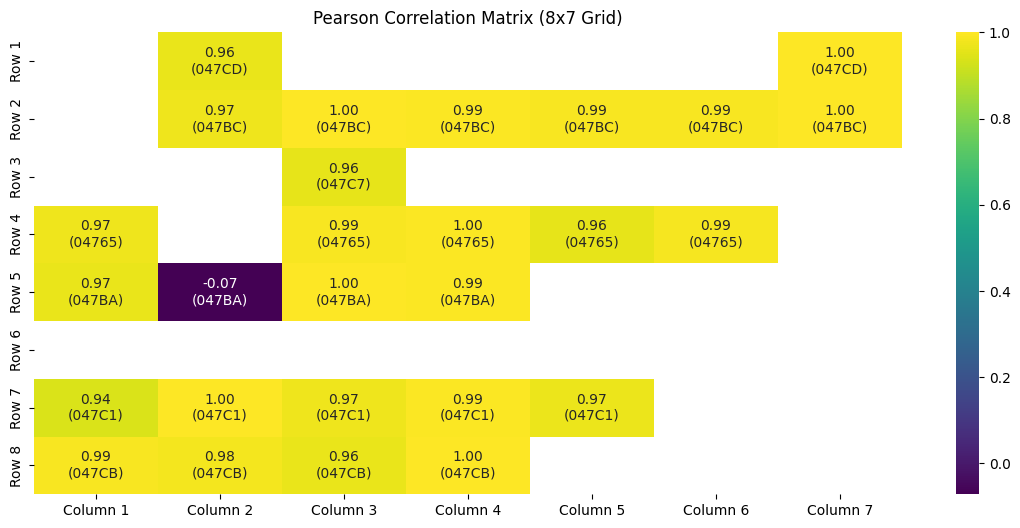

In [25]:
# Create a pivot table with 'Time' as index and 'Sensor ID' as columns
pivot_data = combined_data.pivot_table(index='Time', columns='Sensor ID', values='Temperature')

# Calculate the Pearson correlation matrix
correlation_matrix = pivot_data.corr()

# Create an 8x7 array for the correlation values and annotations
correlation_values = np.full((8, 7), np.nan)
annotations = np.empty((8, 7), dtype=object)

# Place correlation values and sensor names in the 8x7 grid
for sensor_i, pos_i in data.items():
    row_i, col_i = pos_i[0] - 1, pos_i[1] - 1
    for sensor_j, pos_j in data.items():
        row_j, col_j = pos_j[0] - 1, pos_j[1] - 1
        if sensor_i in correlation_matrix.columns and sensor_j in correlation_matrix.columns:
            corr_value = correlation_matrix.loc[sensor_i, sensor_j]
            correlation_values[row_i, col_j] = corr_value
            annotations[row_i, col_j] = f'{corr_value:.2f}\n({sensor_i})'
        else:
            annotations[row_i, col_j] = ''

# Create a DataFrame for the reshaped matrix
reshaped_df = pd.DataFrame(correlation_values, columns=[f'Column {i+1}' for i in range(7)], index=[f'Row {i+1}' for i in range(8)])

# Plot the heatmap with custom annotations
plt.figure(figsize=(14, 6))
sns.heatmap(reshaped_df, annot=annotations, fmt='', cmap='viridis', cbar=True, xticklabels=True, yticklabels=True)

plt.title('Pearson Correlation Matrix (8x7 Grid)')
plt.show()

In [26]:
list_sensors = ['04773','047B7','047B6','047AA','0478A']
timeseries_plot_data = combined_data[combined_data['Sensor ID'].isin(list_sensors)]

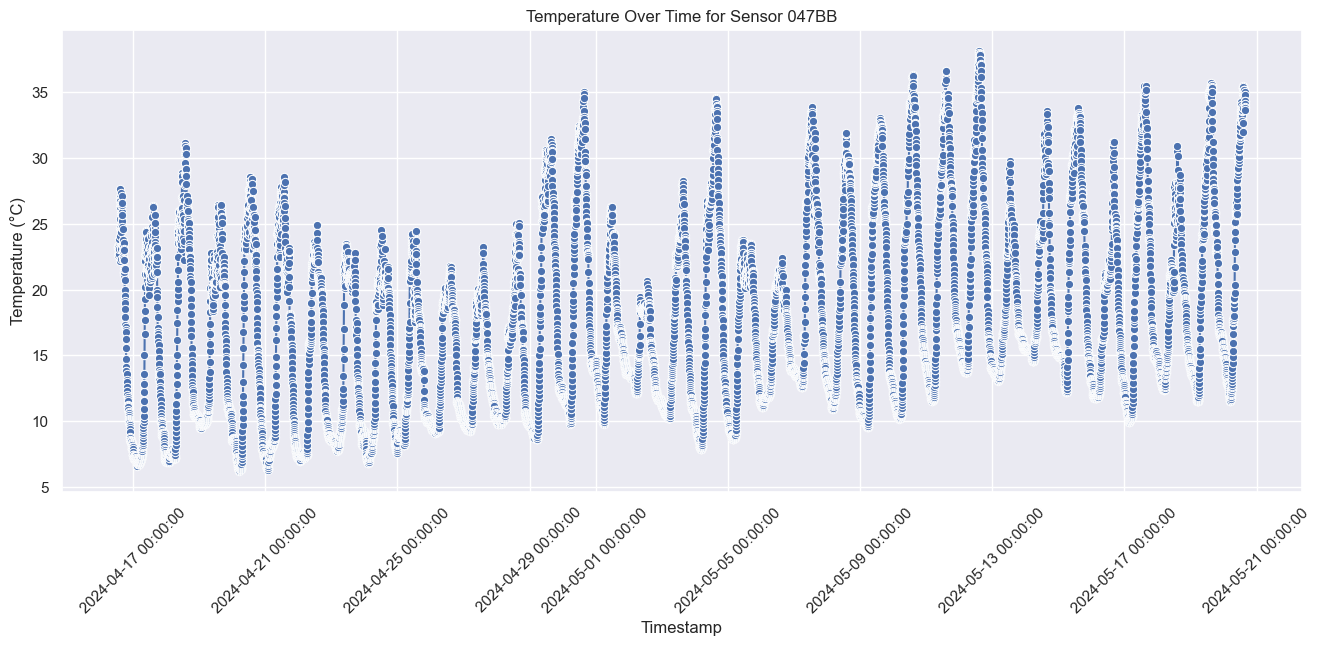

In [71]:
# Specify the sensor ID to plot
# sensor_id = np.random.choice(timeseries_plot_data['Sensor ID'])

# Filter data for the specified sensor
sensor_data = timeseries_plot_data[timeseries_plot_data['Sensor ID'] == '047AA']

# Create a figure for reuse
plt.figure(figsize=(16, 6))
sns.lineplot(x='Time', y='Temperature', data=sensor_data, marker='o')
plt.title(f'Temperature Over Time for Sensor {sensor_id}')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [28]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        current_data_slice = data[i-n_steps:i]
        if not np.isnan(data[i]) and np.isnan(current_data_slice).any():
            X.append(current_data_slice)
            y.append(data[i])
    return np.array(X), np.array(y)

In [29]:
def build_model(input_shape):
    model = ker.models.Sequential([
        ker.layers.Input(shape = input_shape),
        ker.layers.Dense(256,activation='relu'),
        ker.layers.Dense(128,activation='relu'),
        ker.layers.Dense(128,activation='relu'),
        ker.layers.Dense(64,activation='relu'),
        ker.layers.Dense(64,activation='relu'),
        ker.layers.Dense(32,activation='relu'),
        ker.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [30]:
def fill_missing_values(data, model, feature_name, n_steps):
    data_copy = data.copy()
    feature_data = data_copy[feature_name].values
    for i in range(n_steps, len(feature_data)):
        if np.isnan(feature_data[i]):
            if np.isnan(feature_data[i-n_steps:i]).any():
                continue
            X_input = feature_data[i-n_steps:i].reshape(1, -1)
            predicted_value = model.predict(X_input, verbose=0)
            feature_data[i] = np.round(predicted_value.item(), 2)
    data_copy[feature_name] = feature_data
    return data_copy

In [31]:
def train_and_fill(data, feature_name, n_steps):
    feature_data = data[feature_name].values
    X, y = create_sequences(feature_data, n_steps)
    input_shape = (X.shape[1],)
    # print(input_shape)
    model = build_model(input_shape)
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.3)
    filled_data = fill_missing_values(data, model, feature_name, n_steps)
    return filled_data

In [32]:
if combined_data['Temperature'].isnull().sum() > 0 or combined_data['Humidity'].isnull().sum() > 0:
    if combined_data['Temperature'].isnull().sum() > 0:
        combined_data = train_and_fill(combined_data, 'Temperature', 10)
    if combined_data['Humidity'].isnull().sum() > 0:
        combined_data = train_and_fill(combined_data, 'Humidity', 10)
else:
    print('No null values detected!!!!!!')

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 377.7287 - val_loss: 357.3178
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 360.1856 - val_loss: 335.8876
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 337.1319 - val_loss: 315.4482
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 312.5992 - val_loss: 295.9598
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 291.7325 - val_loss: 277.3569
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 276.4251 - val_loss: 259.6225
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 256.2708 - val_loss: 242.6838
Epoch 8/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 242.5567 - val_loss: 226.5486
Epoch 9/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 226.4669 - val_loss: 211.1940
Epoch 10/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 213.9775 - val_loss: 196.6333
Epoch 11/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 191.9046 - val_loss: 182.8245
Epoch 12

In [33]:
final_dataset = combined_data.dropna()

In [34]:
final_dataset.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-14 02:18:22,15.25,92.8,047D6,047D6 T/RH IP67
1,2024-05-04 21:21:36,13.95,71.0,047D6,047D6 T/RH IP67
2,2024-05-04 21:26:37,13.65,71.8,047D6,047D6 T/RH IP67
3,2024-05-04 21:31:35,13.40,72.6,047D6,047D6 T/RH IP67
4,2024-05-04 21:36:36,13.40,73.4,047D6,047D6 T/RH IP67


In [35]:
# Directory path
directory = 'Compare'

# Check if the directory exists
if os.path.exists(directory):
    # If it exists, delete it and all its contents
    shutil.rmtree(directory)

# Create the directory
os.makedirs(directory+'/original_plots')

In [36]:
random_sensors = np.random.choice(final_dataset['Sensor ID'], 8)

In [37]:
random_data = final_dataset[final_dataset['Sensor ID'].isin(random_sensors)]

In [38]:
random_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
33268,2024-04-29 16:39:39,25.80,38.1,047BB,047BB T/RH IP67
33269,2024-04-16 13:46:06,22.20,37.3,047BB,047BB T/RH IP67
33270,2024-05-11 01:40:47,13.20,79.9,047BB,047BB T/RH IP67
33271,2024-05-11 01:35:47,13.30,79.4,047BB,047BB T/RH IP67
33272,2024-05-11 01:30:47,13.35,79.6,047BB,047BB T/RH IP67


In [39]:
# Generate and save individual plots for random_data
marker_styles = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']
colors = sns.color_palette("husl", len(sensor_ids))  # Use a palette with enough colors

In [40]:
# Set the aesthetics for the plot
sns.set(style="darkgrid")

for i, sensor_id in enumerate(random_sensors):
    sensor_data = random_data[random_data['Sensor ID'] == sensor_id]
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Time', y='Temperature', data=sensor_data, marker=marker_styles[i % len(marker_styles)], color=colors[i])
    plt.title(f'Original Temperature Time Series for Sensor ID: {sensor_id}')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Compare/original_plots/original_sensor_{sensor_id}.png')
    plt.close()

In [41]:
def create_video_from_images(folder_path, video_output_path, frame_rate=10.0):
    frames = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    frames.sort()

    frame = cv2.imread(frames[0])
    height, width, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    video = cv2.VideoWriter(video_output_path, fourcc, frame_rate, (width, height))

    prev_frame = cv2.imread(frames[0])
    for frame_path in frames[1:]:
        next_frame = cv2.imread(frame_path)
        
        for i in range(1, 10):
            alpha = i / 10.0
            interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
            video.write(interpolated_frame)

        prev_frame = next_frame

    video.release()
    cv2.destroyAllWindows()

    print(f"Video saved as: {video_output_path}")

In [42]:
def detect_anomalies(sensor_data, sensor_id, temperature_color, humidity_color):
    temperature_folder = os.path.join('anomalies', 'temperature')
    humidity_folder = os.path.join('anomalies', 'humidity')
    os.makedirs(temperature_folder, exist_ok=True)
    os.makedirs(humidity_folder, exist_ok=True)
    
    # Plot for Temperature
    fig, ax = plt.subplots(figsize=(9, 6))
    column = 'Temperature'
    color = temperature_color
    mean = sensor_data[column].mean()
    std_dev = sensor_data[column].std()
    lower_bound = mean - 2 * std_dev
    upper_bound = mean + 2 * std_dev
    
    sensor_data[f'{column}_anomaly'] = np.where(
        (sensor_data[column] < lower_bound) | (sensor_data[column] > upper_bound), 1, 0)
    
    ax.hist(sensor_data[column], bins=30, alpha=0.6, color=color, density=True)
    
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    p = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    ax.plot(x, p, 'k', linewidth=2)
    
    anomalies = sensor_data[sensor_data[f'{column}_anomaly'] == 1]
    ax.scatter(anomalies[column], np.zeros(len(anomalies)), color='r')
    
    ax.set_title(f'Normal Distribution of {column} for Sensor {sensor_id}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.axvline(x=lower_bound, color='b', linestyle='--', label='Lower 2-Sigma')
    ax.axvline(x=upper_bound, color='b', linestyle='--', label='Upper 2-Sigma')
    ax.legend()
    
    fig_path = os.path.join(temperature_folder, f'sensor_{sensor_id}_{column}_anomalies.png')
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.close(fig)
    
    # Plot for Humidity
    fig, ax = plt.subplots(figsize=(9, 6))
    column = 'Humidity'
    color = humidity_color
    mean = sensor_data[column].mean()
    std_dev = sensor_data[column].std()
    lower_bound = mean - 2 * std_dev
    upper_bound = mean + 2 * std_dev
    
    sensor_data[f'{column}_anomaly'] = np.where(
        (sensor_data[column] < lower_bound) | (sensor_data[column] > upper_bound), 1, 0)
    
    ax.hist(sensor_data[column], bins=30, alpha=0.6, color=color, density=True)
    
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    p = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    ax.plot(x, p, 'k', linewidth=2)
    
    anomalies = sensor_data[sensor_data[f'{column}_anomaly'] == 1]
    ax.scatter(anomalies[column], np.zeros(len(anomalies)), color='r')
    
    ax.set_title(f'Normal Distribution of {column} for Sensor {sensor_id}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.axvline(x=lower_bound, color='b', linestyle='--', label='Lower 2-Sigma')
    ax.axvline(x=upper_bound, color='b', linestyle='--', label='Upper 2-Sigma')
    ax.legend()
    
    fig_path = os.path.join(humidity_folder, f'sensor_{sensor_id}_{column}_anomalies.png')
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.close(fig)
    
    return sensor_data

In [43]:
anomalies_list = []
temperature_color = 'green'
humidity_color = 'blue'

for sensor_id, sensor_data in final_dataset.groupby('Sensor ID'):
    sensor_anomalies = detect_anomalies(sensor_data, sensor_id, temperature_color, humidity_color)
    anomalies_list.append(sensor_anomalies)

In [44]:
all_anomalies = pd.concat(anomalies_list)

In [45]:
def get_last_10_records(group):
    return group.tail(100)

In [46]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

last_10_non_anomalous = non_anomalous_data.groupby('Sensor ID', group_keys=False).apply(get_last_10_records).reset_index(drop=True)

C:\Users\malla\AppData\Local\Temp\ipykernel_13804\189072069.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_10_non_anomalous = non_anomalous_data.groupby('Sensor ID', group_keys=False).apply(get_last_10_records).reset_index(drop=True)


In [47]:
last_10_non_anomalous.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Temperature_anomaly,Humidity_anomaly
0,2024-04-28 06:15:24,10.40,90.0,0474D,0474D T/RH IP67,0,0
1,2024-04-28 06:05:26,10.20,89.6,0474D,0474D T/RH IP67,0,0
2,2024-04-28 06:10:25,10.30,90.1,0474D,0474D T/RH IP67,0,0
3,2024-04-28 05:05:29,10.35,89.4,0474D,0474D T/RH IP67,0,0
4,2024-04-28 05:00:29,10.35,88.9,0474D,0474D T/RH IP67,0,0


In [48]:
X_train = last_10_non_anomalous[['Temperature', 'Humidity']]
y_train_temp = last_10_non_anomalous['Temperature']
y_train_humidity = last_10_non_anomalous['Humidity']

In [49]:
last_10_non_anomalous.shape

(5600, 7)

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [51]:
mlp_temp = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
mlp_humidity = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)

In [52]:
mlp_temp.fit(X_train_scaled, y_train_temp)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)

In [53]:
mlp_humidity.fit(X_train_scaled, y_train_humidity)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)

In [54]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

In [55]:
anomalies.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Temperature_anomaly,Humidity_anomaly
75873,2024-05-20 13:18:34,33.90,28.9,0474D,0474D T/RH IP67,1,1
75877,2024-05-20 13:38:33,32.60,28.3,0474D,0474D T/RH IP67,1,1
232588,2024-04-30 12:18:06,31.55,34.0,04750,04750 T/RH IP67,1,1
232590,2024-04-30 12:28:04,31.60,34.3,04750,04750 T/RH IP67,1,1
232592,2024-04-30 12:38:06,32.20,33.8,04750,04750 T/RH IP67,1,1


In [56]:
anomalies.loc[anomalies['Temperature_anomaly'] == 1, 'Temperature'] = 0
anomalies.loc[anomalies['Humidity_anomaly'] == 1, 'Humidity'] = 0

In [57]:
anomalies.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Temperature_anomaly,Humidity_anomaly
75873,2024-05-20 13:18:34,0.0,0.0,0474D,0474D T/RH IP67,1,1
75877,2024-05-20 13:38:33,0.0,0.0,0474D,0474D T/RH IP67,1,1
232588,2024-04-30 12:18:06,0.0,0.0,04750,04750 T/RH IP67,1,1
232590,2024-04-30 12:28:04,0.0,0.0,04750,04750 T/RH IP67,1,1
232592,2024-04-30 12:38:06,0.0,0.0,04750,04750 T/RH IP67,1,1


In [58]:
anomalies['Temperature'] = np.round(mlp_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(mlp_humidity.predict(X_anomalies_scaled), 2)

In [59]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])

In [60]:
final_processed_data = all_anomalies.copy()

In [61]:
final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Temperature_anomaly,Humidity_anomaly
75873,2024-05-20 13:18:34,34.09,30.92,0474D,0474D T/RH IP67,1,1
75877,2024-05-20 13:38:33,32.73,29.47,0474D,0474D T/RH IP67,1,1
232588,2024-04-30 12:18:06,31.57,33.97,04750,04750 T/RH IP67,1,1
232590,2024-04-30 12:28:04,31.62,34.26,04750,04750 T/RH IP67,1,1
232592,2024-04-30 12:38:06,32.23,33.78,04750,04750 T/RH IP67,1,1


In [62]:
filtered_random_data = final_processed_data[final_processed_data['Sensor ID'].isin(random_sensors)]

In [63]:
filtered_random_data['Sensor ID'].unique()

array(['0475C', '0477F', '047AA', '047AD', '047B6', '047BB', '047BC',
       '047C1'], dtype=object)

In [64]:
os.makedirs(directory+'/filtered_plots', exist_ok=True)

In [65]:
# Generate and save individual plots for filtered_random_data
for i, sensor_id in enumerate(random_sensors):
    sensor_data = filtered_random_data[filtered_random_data['Sensor ID'] == sensor_id]
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Time', y='Temperature', data=sensor_data, marker=marker_styles[i % len(marker_styles)], color=colors[i])
    plt.title(f'Filtered Temperature Time Series for Sensor ID: {sensor_id}')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Compare/filtered_plots/filtered_sensor_{sensor_id}.png')
    plt.close()

In [66]:
# Parameters for the video
frame_rate = 1  # Frame rate (1 frame per second)
frame_size = (1600, 600)  # Frame size (width, height), each plot is 800x600
frame_repeat = 5  # Number of times each frame should be repeated

# Create directories to save plots if they don't exist
os.makedirs('Compare/original_plots', exist_ok=True)
os.makedirs('Compare/filtered_plots', exist_ok=True)

# Initialize the video writer
out = cv2.VideoWriter('comparison_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), frame_rate, frame_size)

# Get the list of images for both datasets
original_images = sorted(glob.glob('Compare/original_plots/original_sensor_*.png'))
filtered_images = sorted(glob.glob('Compare/filtered_plots/filtered_sensor_*.png'))

# Combine images side by side and write to the video
for original_image, filtered_image in zip(original_images, filtered_images):
    img1 = cv2.imread(original_image)
    img2 = cv2.imread(filtered_image)
    
    # Resize images to ensure they have the same height
    img1_resized = cv2.resize(img1, (800, 600))
    img2_resized = cv2.resize(img2, (800, 600))
    
    # Combine images side by side
    combined_img = np.hstack((img1_resized, img2_resized))
    
    # Write the combined image to the video multiple times
    for _ in range(frame_repeat):
        out.write(combined_img)

# Release the video writer
out.release()